In [1]:
import pandas as pd

BASE_DIR = "/Users/ishaharris/Projects/ribolings/data/freqs"

wt = pd.read_csv(f"{BASE_DIR}/wt_freqs.csv", index_col=0)
recode = pd.read_csv(f"{BASE_DIR}/recode_freqs.csv", index_col=0)
monoaa = pd.read_csv(f"{BASE_DIR}/monoaa_freqs.csv", index_col=0)
sim = pd.read_csv(f"{BASE_DIR}/simulation_freqs.csv", index_col=0)


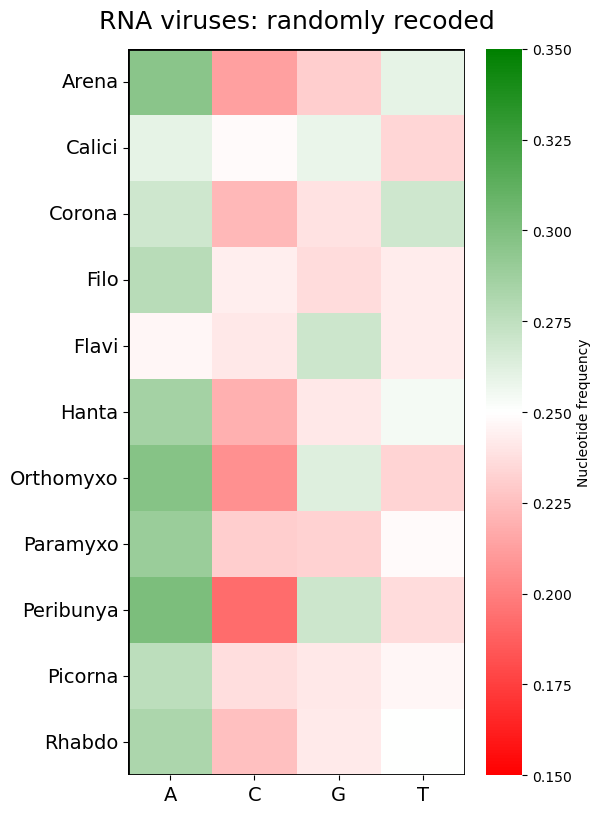

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

# Example: track dataset type
dataset_type = "recode"  # options: "wt", "recode", "monoaa", "sim"

titles = {
    "wt": "RNA viruses: wild-type",
    "recode": "RNA viruses: randomly recoded",
    "monoaa": "RNA viruses: mono amino-acid",
    "sim": "RNA viruses: simulated drift"
}

# choose the dataset
if dataset_type == "wt":
    data = wt
elif dataset_type == "recode":
    data = recode
elif dataset_type == "monoaa":
    data = monoaa
elif dataset_type == "sim":
    data = sim

# Sort rows alphabetically by index
data = data.sort_index()

title = titles[dataset_type]

def plot_nt_heatmap(df, title=title, vmin=0.15, vmax=0.35, savepath=None):
    """
    Plot nucleotide frequency heatmap for virus families.

    Parameters:
        df (pd.DataFrame): Rows = Virus families, Columns = A/C/G/T frequencies.
        title (str): Title of the heatmap.
        vmin, vmax (float): Colour scale limits.
        savepath (str): Optional, if given saves figure to this path.
    """
    # Custom colormap: red -> white -> green
    cmap = LinearSegmentedColormap.from_list("red_white_green", ["red", "white", "green"])

    nrows, ncols = df.shape

    # Slightly smaller canvas, keep width:height = 2:1 per cell
    cell_width = 1.5
    cell_height = 0.75
    fig_w = ncols * cell_width
    fig_h = nrows * cell_height

    plt.figure(figsize=(fig_w, fig_h))
    ax = sns.heatmap(
        df,
        annot=False,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        center=0.25,          # neutral = white
        cbar_kws={"label": "Nucleotide frequency"},
        square=False,         # allow rectangles
        linewidths=0          # no per-cell borders
    )

    # Add only one bold border around entire heatmap
    rect = patches.Rectangle(
        (0, 0), ncols, nrows,
        fill=False, color="black", linewidth=2
    )
    ax.add_patch(rect)

    # Bigger font for labels and title
    plt.title(title, fontsize=18, pad=15)
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)
    plt.xlabel("")
    plt.ylabel("")

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()

# Example usage:
plot_nt_heatmap(data)


# Residual

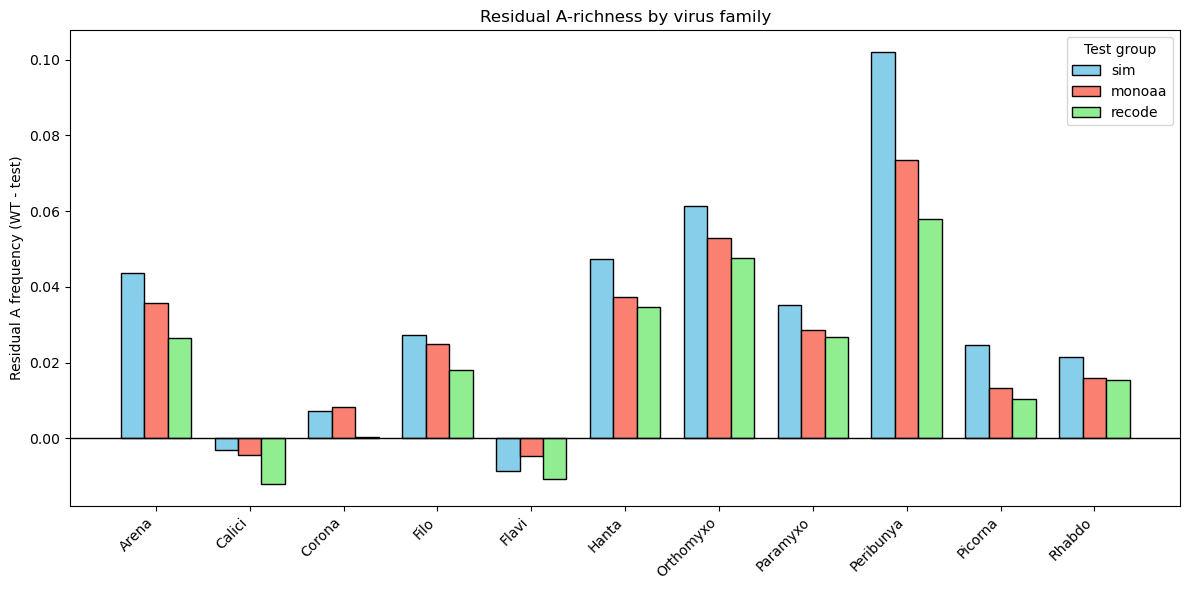

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Columns: virus families, Rows: A frequencies
wt_a = wt['A']

test_groups = {
    'sim': sim['A'],
    'monoaa': monoaa['A'],
    'recode': recode['A']
}

# Sort virus families alphabetically
virus_families = sorted(wt.index)

# Residuals: WT - test group
residuals = {name: (wt_a - series).reindex(virus_families) for name, series in test_groups.items()}

# Bar settings
x = np.arange(len(virus_families))  # positions for virus families
width = 0.25  # width of each bar

plt.figure(figsize=(12, 6))

colors = {'sim': 'skyblue', 'monoaa': 'salmon', 'recode': 'lightgreen'}

for i, (name, values) in enumerate(residuals.items()):
    plt.bar(x + i*width - width, values.values, width=width, label=name, color=colors[name], edgecolor='black')

plt.axhline(0, color='black', linewidth=1)
plt.xticks(x, virus_families, rotation=45, ha='right')
plt.ylabel("Residual A frequency (WT - test)")
plt.title("Residual A-richness by virus family")
plt.legend(title="Test group")
plt.tight_layout()
plt.show()


# Raw Arich per group

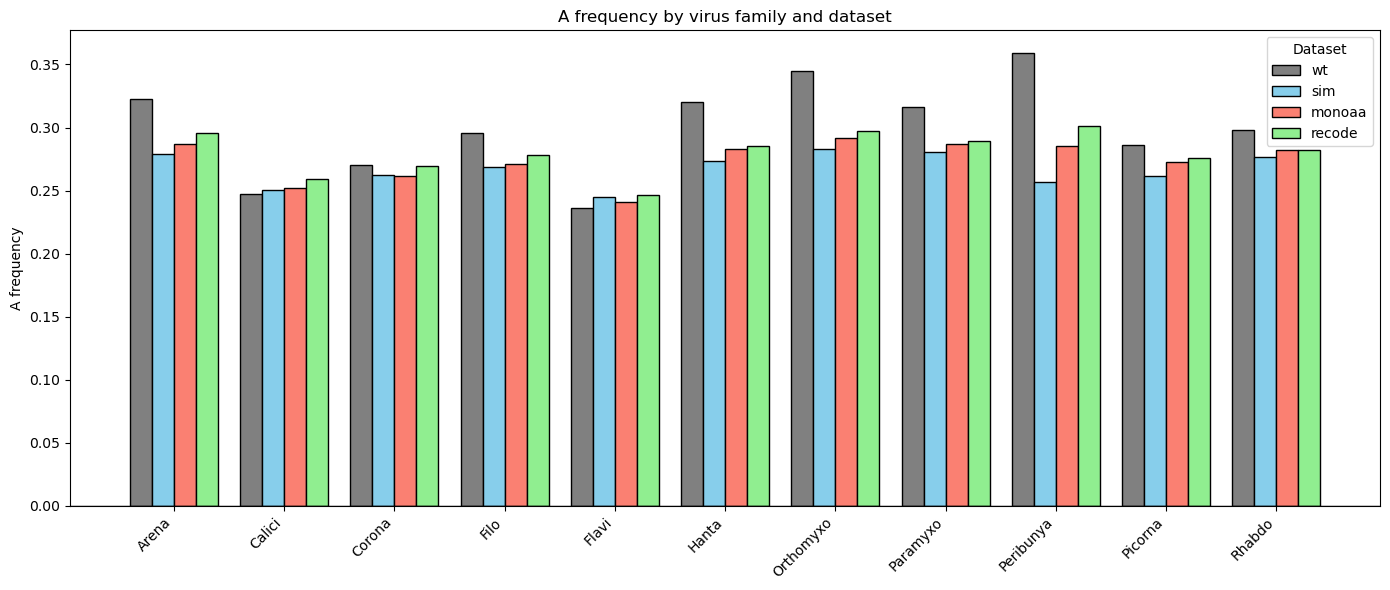

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Columns: virus families, Rows: A frequencies
virus_families = sorted(wt.index)

# Raw A frequencies
freqs = {
    'wt': wt['A'].reindex(virus_families),
    'sim': sim['A'].reindex(virus_families),
    'monoaa': monoaa['A'].reindex(virus_families),
    'recode': recode['A'].reindex(virus_families)
}

# Bar settings
x = np.arange(len(virus_families))  # positions for virus families
width = 0.2  # width of each bar

plt.figure(figsize=(14, 6))

colors = {'wt': 'gray', 'sim': 'skyblue', 'monoaa': 'salmon', 'recode': 'lightgreen'}

for i, (name, values) in enumerate(freqs.items()):
    plt.bar(x + i*width - 1.5*width, values.values, width=width, label=name, color=colors[name], edgecolor='black')

plt.axhline(0, color='black', linewidth=1)
plt.xticks(x, virus_families, rotation=45, ha='right')
plt.ylabel("A frequency")
plt.title("A frequency by virus family and dataset")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


# Nt bias driven by aa bias vs codon bias

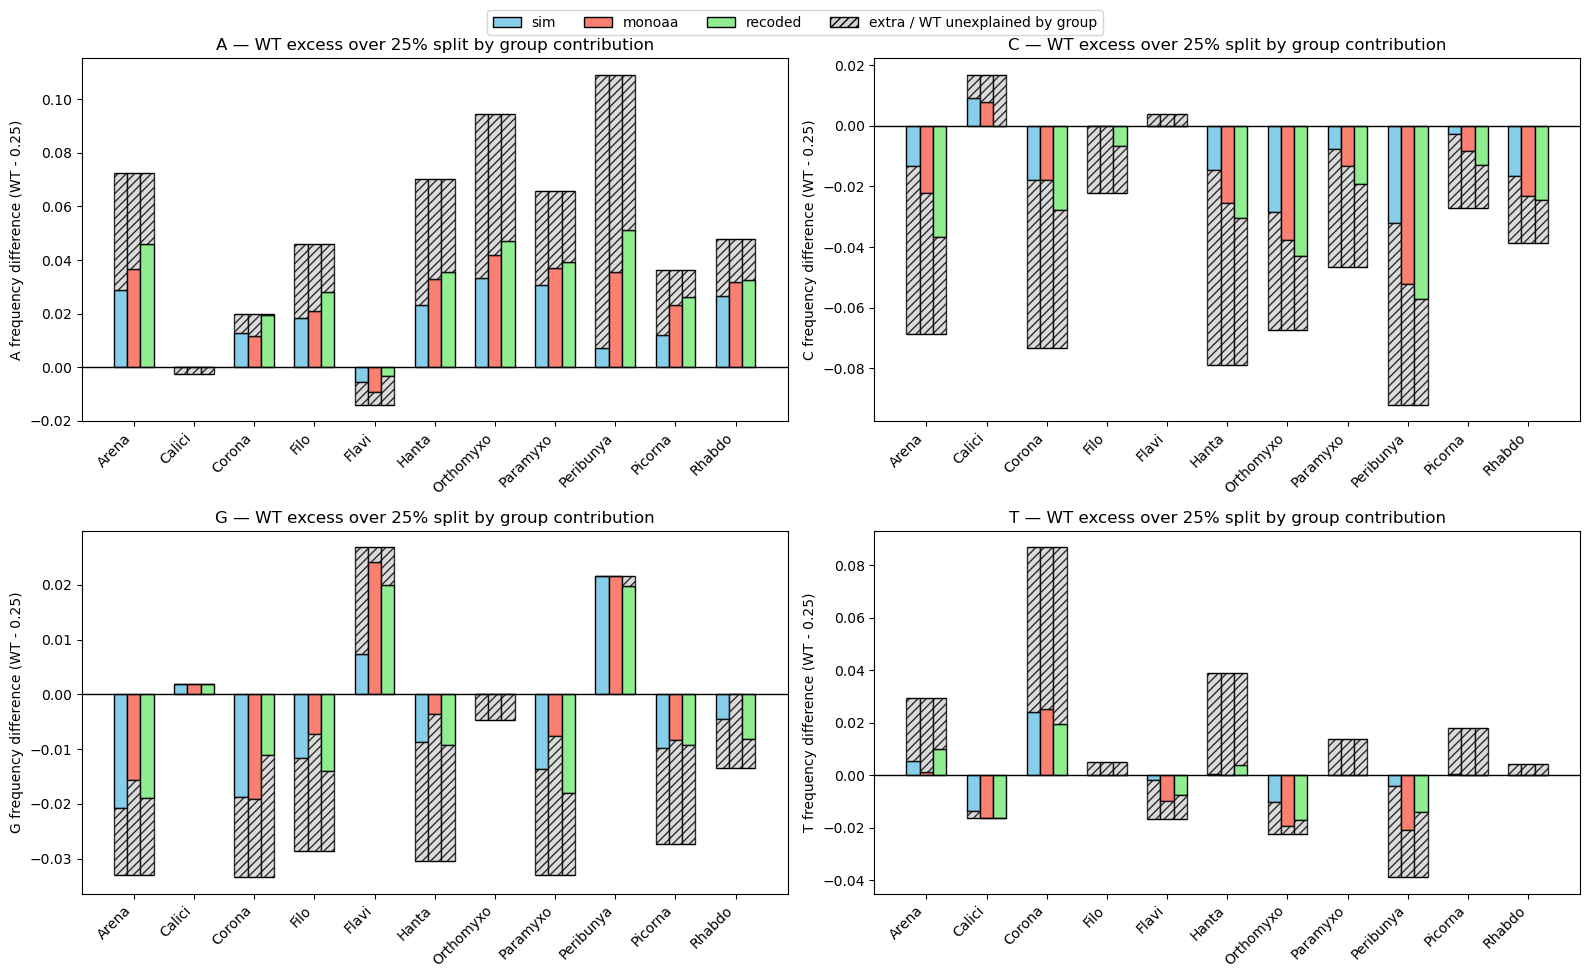

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Assumes these exist in your namespace:
# wt, sim, monoaa, recode  (pandas DataFrames/Series indexed by virus_family, with columns 'A','C','G','T')
# Example: wt['A'], sim['A'], etc.

bases = ['A', 'C', 'G', 'T']
test_groups = {
    'sim': sim,
    'monoaa': monoaa,
    'recode': recode
}
group_names = list(test_groups.keys())

# Sort virus families alphabetically (keeps consistent ordering)
virus_families = sorted(wt.index)
n_families = len(virus_families)

# plotting layout: 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=False)
axes = axes.flatten()

# Colors
group_colors = {'sim': 'skyblue', 'monoaa': 'salmon', 'recode': 'lightgreen'}
extra_color = 'lightgray'  # color for the "extra / unexplained" portion
edgecolor = 'black'
width = 0.22

for ax_idx, base in enumerate(bases):
    ax = axes[ax_idx]
    wt_base = wt[base].reindex(virus_families).astype(float)
    # compute WT excess relative to 25%
    wt_excess = wt_base - 0.25  # can be negative
    x = np.arange(n_families)

    # For each group, compute driven and extra arrays (same length as families)
    driven_dict = {}
    extra_dict = {}

    for gname, gdf in test_groups.items():
        g_series = gdf[base].reindex(virus_families).astype(float)
        group_excess = g_series - 0.25

        # driven: group can explain up to the overlapping magnitude, but only if signs match
        driven = np.zeros_like(wt_excess.values, dtype=float)
        for i in range(len(wt_excess)):
            we = wt_excess.iloc[i]
            ge = group_excess.iloc[i]
            if we == 0:
                driven[i] = 0.0
            else:
                # only if group excess and wt excess have same sign does group explain part
                if np.sign(we) == np.sign(ge) and ge != 0:
                    driven[i] = np.sign(we) * min(abs(we), abs(ge))
                else:
                    driven[i] = 0.0
        driven_dict[gname] = driven
        extra = wt_excess.values - driven  # can be positive/negative/zero
        extra_dict[gname] = extra

    # Plot three bars per family (sim, monoaa, recode)
    offsets = np.array([-width, 0, width])  # to place 3 bars side-by-side
    for i, gname in enumerate(group_names):
        xpos = x + offsets[i]
        driven = driven_dict[gname]
        extra = extra_dict[gname]

        # For stacking with positive/negative values, we handle order and bottoms carefully.
        # We'll draw 'driven' first, then 'extra' on top so they sum to wt_excess.
        # If values negative, matplotlib will stack downward correctly using bottom parameter.

        # If driven and extra have mixed signs we still stack them in the same order so that
        # driven + extra == wt_excess visually.
        ax.bar(xpos, driven, width=width, label=f'{gname} (driven)' if i == 0 else "", 
               color=group_colors[gname], edgecolor=edgecolor)
        ax.bar(xpos, extra, width=width, bottom=driven, label=f'{gname} (extra)' if i == 0 else "",
               color=extra_color, edgecolor=edgecolor, hatch='////', alpha=0.8)

        # Optionally outline the total (wt_excess) with a thin line/bar top marker:
        # Draw a thin black line at the top of the stacked bar to mark the total WT_excess
        for xi, d, e in zip(xpos, driven, extra):
            total = d + e
            # a small vertical cap to mark total
            ax.plot([xi - width/2 + 0.01, xi + width/2 - 0.01], [total, total], color='k', linewidth=0.8)

    # Axis formatting
    ax.axhline(0, color='black', linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(virus_families, rotation=45, ha='right')
    ax.set_title(f'{base} — WT excess over 25% split by group contribution')
    ax.set_ylabel(f'{base} frequency difference (WT - 0.25)')

    # Make a legend that explains colors only once (per figure)
    # We'll create a custom legend after the loop

# Create unified legend (explain driven color vs extra)
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor=group_colors['sim'], edgecolor=edgecolor, label='sim'),
    Patch(facecolor=group_colors['monoaa'], edgecolor=edgecolor, label='monoaa'),
    Patch(facecolor=group_colors['recode'], edgecolor=edgecolor, label='recoded'),
    Patch(facecolor=extra_color, edgecolor=edgecolor, hatch='////', label='extra / WT unexplained by group')
]
fig.legend(handles=legend_handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.98))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Updated legend

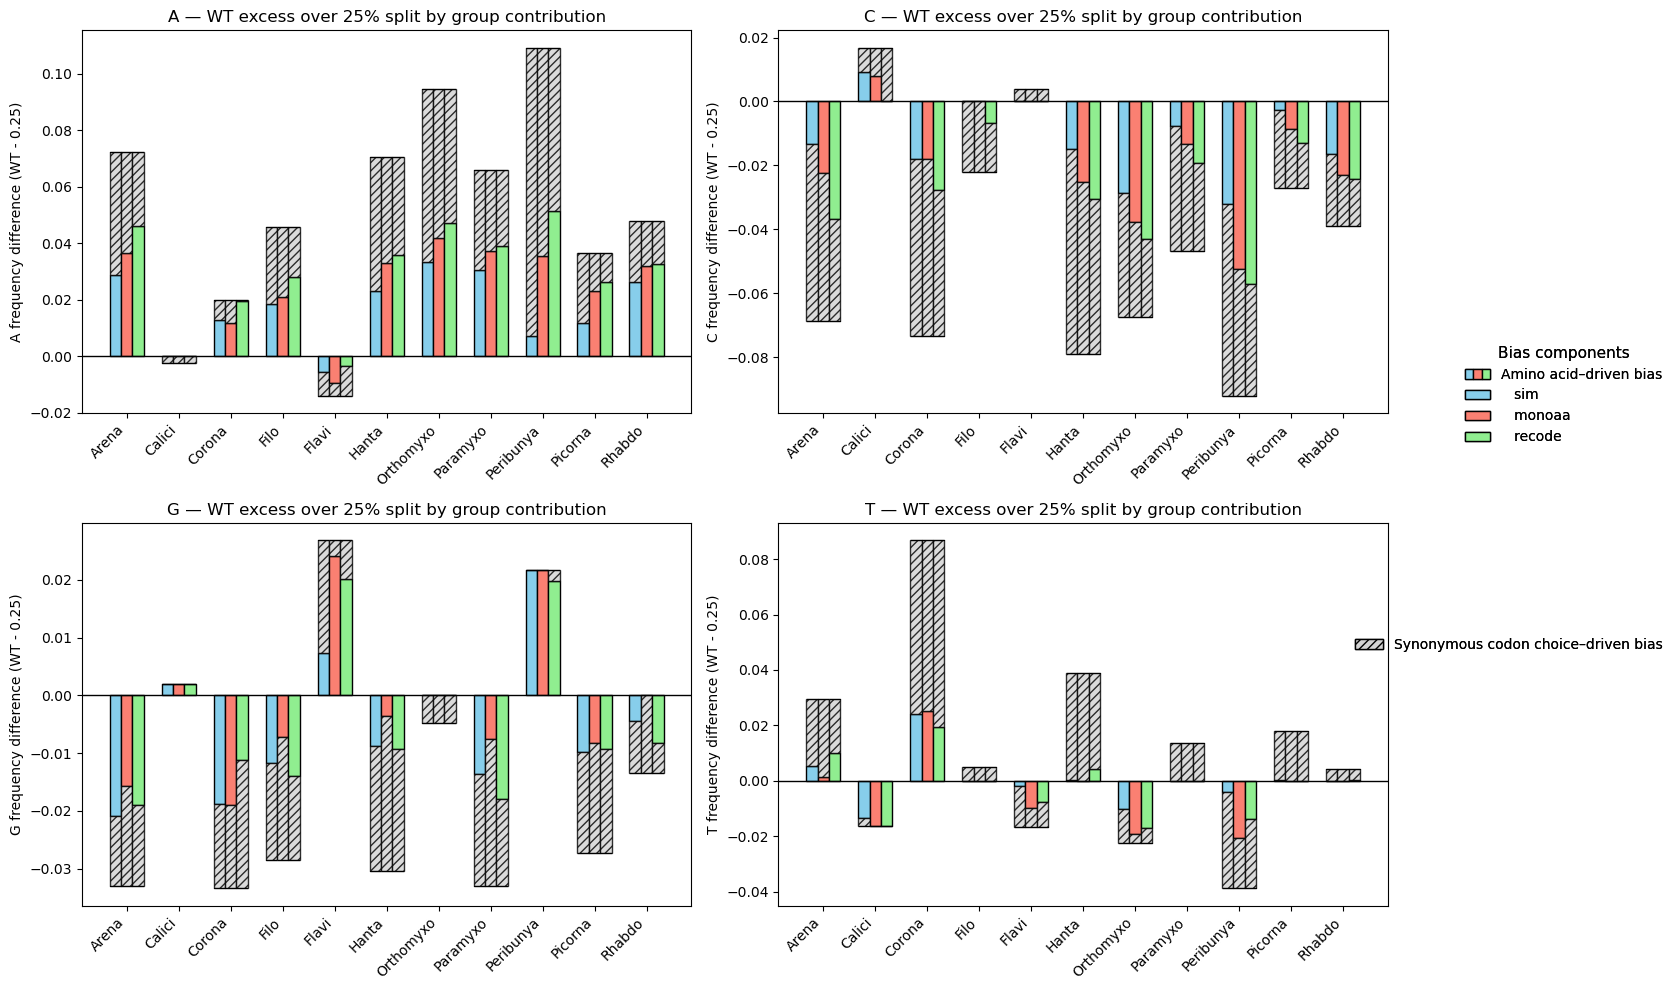

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch, Rectangle
from matplotlib.legend_handler import HandlerPatch

# --- Assumes these exist in your namespace:
# wt, sim, monoaa, recode (pandas DataFrames/Series indexed by virus_family, with columns 'A','C','G','T')

bases = ['A', 'C', 'G', 'T']
test_groups = {
    'sim': sim,
    'monoaa': monoaa,
    'recode': recode
}
group_names = list(test_groups.keys())

virus_families = sorted(wt.index)
n_families = len(virus_families)

fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=False)
axes = axes.flatten()

# Colors
group_colors = {'sim': 'skyblue', 'monoaa': 'salmon', 'recode': 'lightgreen'}
extra_color = 'lightgray'
edgecolor = 'black'
width = 0.22

for ax_idx, base in enumerate(bases):
    ax = axes[ax_idx]
    wt_base = wt[base].reindex(virus_families).astype(float)
    wt_excess = wt_base - 0.25
    x = np.arange(n_families)

    driven_dict = {}
    extra_dict = {}

    for gname, gdf in test_groups.items():
        g_series = gdf[base].reindex(virus_families).astype(float)
        group_excess = g_series - 0.25

        driven = np.zeros_like(wt_excess.values, dtype=float)
        for i in range(len(wt_excess)):
            we = wt_excess.iloc[i]
            ge = group_excess.iloc[i]
            if we == 0:
                driven[i] = 0.0
            elif np.sign(we) == np.sign(ge) and ge != 0:
                driven[i] = np.sign(we) * min(abs(we), abs(ge))
            else:
                driven[i] = 0.0
        driven_dict[gname] = driven
        extra_dict[gname] = wt_excess.values - driven

    offsets = np.array([-width, 0, width])
    for i, gname in enumerate(group_names):
        xpos = x + offsets[i]
        driven = driven_dict[gname]
        extra = extra_dict[gname]

        # AA-driven
        ax.bar(
            xpos, driven, width=width,
            color=group_colors[gname], edgecolor=edgecolor
        )
        # Codon-driven
        ax.bar(
            xpos, extra, width=width, bottom=driven,
            color=extra_color, edgecolor=edgecolor, hatch='////', alpha=0.8
        )

        # Mark WT total
        for xi, d, e in zip(xpos, driven, extra):
            total = d + e
            ax.plot([xi - width/2 + 0.01, xi + width/2 - 0.01],
                    [total, total], color='k', linewidth=0.8)

    ax.axhline(0, color='black', linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(virus_families, rotation=45, ha='right')
    ax.set_title(f'{base} — WT excess over 25% split by group contribution')
    ax.set_ylabel(f'{base} frequency difference (WT - 0.25)')

# -------------------------
# Custom legend construction
# -------------------------

class SplitColorPatch(Patch):
    """Custom multicolor patch for legend."""
    def __init__(self, colors, **kwargs):
        super().__init__(**kwargs)
        self.colors = colors

class SplitColorHandler(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent,
                       width, height, fontsize, trans):
        patches = []
        n = len(orig_handle.colors)
        step = width / n
        for i, c in enumerate(orig_handle.colors):
            rect = Rectangle(
                (xdescent + i * step, ydescent),
                step, height,
                facecolor=c, edgecolor='black',
                transform=trans
            )
            patches.append(rect)
        return patches

# Main AA-driven bias patch (multicolor)
aa_driven_patch = SplitColorPatch(
    colors=[group_colors['sim'], group_colors['monoaa'], group_colors['recode']],
    label='Amino acid–driven bias'
)
# Synonymous codon choice–driven bias
codon_patch = Patch(
    facecolor=extra_color,
    edgecolor=edgecolor,
    hatch='////',
    label='Synonymous codon choice–driven bias'
)

# Sublegend (smaller, indented)
sublegend_entries = [
    Patch(facecolor=group_colors['sim'], edgecolor=edgecolor, label='   sim'),
    Patch(facecolor=group_colors['monoaa'], edgecolor=edgecolor, label='   monoaa'),
    Patch(facecolor=group_colors['recode'], edgecolor=edgecolor, label='   recode'),
]

# First main legend: AA-driven bias + subentries
legend1 = fig.legend(
    handles=[aa_driven_patch] + sublegend_entries,
    handler_map={SplitColorPatch: SplitColorHandler()},
    loc='center right',
    bbox_to_anchor=(1.05, 0.6),
    frameon=False,
    title="Bias components",
    title_fontsize=11,
    labelspacing=0.5,
    handlelength=1.8,
    handletextpad=0.8
)

# Second main legend: Codon-driven bias
legend2 = fig.legend(
    handles=[codon_patch],
    loc='center right',
    bbox_to_anchor=(1.05, 0.35),
    frameon=False,
    labelspacing=0.8,
    handlelength=2
)

# Add legends as artists so they both appear
fig.add_artist(legend1)
fig.add_artist(legend2)

plt.tight_layout(rect=[0, 0, 0.88, 1])  # leave room for legends on right
plt.show()
